In [1]:
import numpy as np
import jax.numpy as jnp
from jax import random, jit, jacfwd, vmap
from jax.numpy.linalg import inv
from jax.nn import tanh, sigmoid

from scipy.optimize import minimize
from scipy.stats import norm

import matplotlib.pyplot as plt

np.random.seed(1)

<frozen importlib._bootstrap>:228: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject
Matplotlib created a temporary config/cache directory at /tmp/matplotlib-dc0pwtu6 because the default path (/home/jaron/.cache/matplotlib) is not a writable directory; it is highly recommended to set the MPLCONFIGDIR environment variable to a writable directory, in particular to speed up the import of Matplotlib and to better support multiprocessing.


2024-02-25 12:24:54.132698: E external/xla/xla/stream_executor/cuda/cuda_driver.cc:282] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected


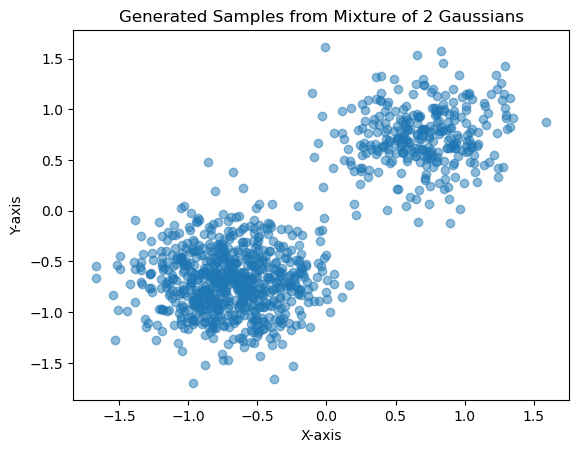

In [2]:
# Chat GPT generated code to sample from mixture of 2 2-dimensional Gaussians

# Generate samples from a 2-dimensional mixture of 2 Gaussians.
def generate_samples(num_samples, means, covariances, weights):
    num_components = len(means)

    # Choose components for each sample based on the weights
    component_choices = np.random.choice(num_components, size=num_samples, p=weights)

    # Generate samples for each component
    samples = np.zeros((num_samples, len(means[0])))

    for i in range(num_components):
        component_samples = np.random.multivariate_normal(means[i], covariances[i], size=num_samples)
        mask = (component_choices == i)
        samples[mask, :] = component_samples[mask, :]

    return samples

# Example usage:
# Set up parameters for two Gaussians
mean1 = np.array([-.7, -.7])
covariance1 = np.array([[.1, 0.], [0., .1]])
precision1 = inv(covariance1)
weight1 = .7

mean2 = np.array([.7, .7])
covariance2 = np.array([[.1, 0.], [0., .1]])
precision2 = inv(covariance2)
weight2 = .3

# Generate synthetic data
num_samples = 1000
means = [mean1, mean2]
covariances = [covariance1, covariance2]
weights = [weight1, weight2]
generated_samples = generate_samples(num_samples, means, covariances, weights)

plt.scatter(generated_samples[:, 0], generated_samples[:, 1], alpha=0.5)
plt.title('Generated Samples from Mixture of 2 Gaussians')
plt.xlabel('X-axis')
plt.ylabel('Y-axis')
plt.show()

In [3]:
# goal is to use a neural network to map Gaussian noise to samples from posterior parameter distribution

In [4]:
# problem dimension
d = 2

# neural net dimension
h1 = 4
# h2 = 2
# h3 = 2

# determine shapes of weights/biases = [Wih, bih, Who, bho]
# shapes = [[h1, d], [h1], [h2, h1], [h2], [h3, h2], [h3], [d, h3], [d]]
shapes = [[h1, d], [h1], [d, h1], [d]]
k_params = []
n_params = 0
for shape in shapes:
    k_params.append(n_params)
    n_params += np.prod(shape)
k_params.append(n_params)

# initialize parameters
lmbda = np.zeros(n_params)
for k1,k2,shape in zip(k_params, k_params[1:], shapes):
    if len(shape)>1:
        stdv = 2./np.sqrt(2*shape[-1])
        lmbda[k1:k2] = np.log2(np.random.uniform(0., stdv, k2-k1,))
    else:
        lmbda[k1:k2] = np.random.randn(k2-k1,) / np.sqrt(2.)
    
# reshape parameters into weight matrices and bias vectors
def reshape(params):
    # params is a vector = [Wih, bih, Who, bho]
    return [np.reshape(params[k1:k2], shape) for k1, k2, shape in
            zip(k_params, k_params[1:], shapes)]

@jit
def nn(y, lmbda):
    
    # weights and biases of nn
    W1, b1, W4, b4 = reshape(lmbda)
    
    # hidden layer
    h = tanh(jnp.einsum('ij,...j->...i', jnp.exp2(W1), y) + b1)
    
    # hidden layer
    # h = tanh(jnp.einsum('ij,...j->...i', jnp.exp2(W2), h) + b2)
    
    # hidden layer
    # h = tanh(jnp.einsum('ij,...j->...i', jnp.exp2(W3), h) + b3)
    
    # output
    z = jnp.einsum('ij,...j->...i', jnp.exp2(W4), h) + b4
    
    return z

# gradient of nn output w.r.t. parameters
grad_nn = jit(jacfwd(nn, 1))

# @jit 
# def inv_nn(z, lmbda):
    
#     # weights and biases of nn
#     W1, b1, W3, b3 = reshape(lmbda)
    
#     # hidden layer
#     h = jnp.einsum('ij,...j->...i', inv(W3), z - b3)
    
#     # input 
#     # h = jnp.einsum('ij,...j->...i', inv(W2), jnp.arctanh(h) - b2)
    
#     # input 
#     y = jnp.einsum('ij,...j->...i', inv(W1), jnp.arctanh(h) - b1)

#     return y 
    
# gradient of nn output w.r.t. parameters
jac_nn = jit(jacfwd(nn, 0))
# jac_inv_nn = jit(jacfwd(inv_nn, 0))

@jit
def log_abs_det(yi, lmbda):
    return jnp.log(jnp.abs(jnp.linalg.det(jac_nn(yi, lmbda))))

# gradient of entropy of approximating distribution w.r.t. lmbda
grad_log_abs_det = jit(jacfwd(log_abs_det, 1))

In [5]:
# nll of true posterior
@jit 
def neg_log_likelihood(yi, lmbda):
    zi = nn(yi, lmbda)
    # l1 = weight1 * N(zi | m1, C1)
    # l2 = weight2 * N(zi | m2, C2)
    l1 = weight1 * 1./((2.*jnp.pi)**(d/2.)) * (1./jnp.sqrt(jnp.linalg.det(covariance1))) * jnp.exp(-jnp.einsum('i,ij,j', zi-mean1, precision1, zi-mean1) / 2.)
    l2 = weight2 * 1./((2.*jnp.pi)**(d/2.)) * (1./jnp.sqrt(jnp.linalg.det(covariance2))) * jnp.exp(-jnp.einsum('i,ij,j', zi-mean2, precision2, zi-mean2) / 2.)
    return -jnp.log(l1 + l2)
grad_neg_log_likelihood = jit(jacfwd(neg_log_likelihood, 1))

# kl divergence btw q(lmbda) and p(z | X)
def kl(lmbda, n_sample=10):
    
    # use nn to sample parameters
    # y = np.random.random(size=[n_sample, d])
    y = np.random.randn(n_sample, d)
    z = nn(y, lmbda)
    
    # evaluate model fitness 
    KL = 0.
    for yi, zi in zip(y, z):
        # divergence btw true posterior
        KL += neg_log_likelihood(yi, lmbda) / n_sample
        # entropy
        KL -= log_abs_det(yi, lmbda) / n_sample
        
    return KL

# make sure NN is flexible enough to capture true posterior
def grad_kl(lmbda, n_sample=10):
    
    # use nn to sample parameters
    # y = np.random.random(size=[n_sample, d])
    y = np.random.randn(n_sample, d)
    z = nn(y, lmbda)
    
    grad_KL = 0.
    for yi, zi in zip(y, z):
        grad_KL += grad_neg_log_likelihood(yi, lmbda) / n_sample
        grad_KL -= grad_log_abs_det(yi, lmbda) / n_sample
        
    return grad_KL

In [6]:
# adam from chat gpt
def adam_optimizer(f, grad_f, initial_params, learning_rate=0.005, beta1=0.9, beta2=0.999, epsilon=1e-8, max_iterations=10000, tol=1e-6):
    """
    ADAM optimizer for minimizing a function.

    Parameters:
    - grad_f: Gradient function that returns the gradient of the objective function.
    - initial_params: Initial guess for the parameters.
    - learning_rate: Step size for the optimization (default: 0.001).
    - beta1: Exponential decay rate for the first moment estimate (default: 0.9).
    - beta2: Exponential decay rate for the second moment estimate (default: 0.999).
    - epsilon: Small constant to prevent division by zero (default: 1e-8).
    - max_iterations: Maximum number of iterations (default: 1000).
    - tol: Tolerance to stop optimization when the change in parameters is below this value (default: 1e-6).

    Returns:
    - Optimal parameters.
    """
    params = initial_params
    m = np.zeros_like(params)
    v = np.zeros_like(params)
    t = 0

    while t < max_iterations:
        t += 1
        
        if t%10==0:
            print("KL {:.3f}".format(f(params, n_sample=10)))

        gradient = grad_f(params)
        
        m = beta1 * m + (1 - beta1) * gradient
        v = beta2 * v + (1 - beta2) * (gradient ** 2)

        m_hat = m / (1 - beta1 ** t)
        v_hat = v / (1 - beta2 ** t)

        params -= learning_rate * m_hat / (np.sqrt(v_hat) + epsilon)

        if np.linalg.norm(learning_rate * m_hat / (np.sqrt(v_hat) + epsilon)) < tol:
            break

    return params

In [7]:
lmbda = adam_optimizer(kl, grad_kl, lmbda)

KL 22.700
KL 21.259
KL 18.478
KL 14.176
KL 13.707
KL 12.913
KL 12.731
KL 10.664
KL 9.056
KL 8.906
KL 7.199
KL 6.670
KL 5.737
KL 6.027
KL 4.430
KL 5.840
KL 5.563
KL 5.207
KL 4.665
KL 5.338
KL 4.105
KL 4.718
KL 4.288
KL 4.458
KL 4.124
KL 5.292
KL 4.613
KL 3.861
KL 4.060
KL 4.815
KL 4.930
KL 4.930
KL 4.655
KL 4.990
KL 4.561
KL 3.725
KL 5.407
KL 5.225
KL 4.006
KL 4.537
KL 4.329
KL 3.801
KL 5.005
KL 4.811
KL 4.594
KL 3.785
KL 3.682
KL 3.912
KL 4.871
KL 4.140
KL 4.290
KL 4.690
KL 4.841
KL 4.946
KL 3.668
KL 3.536
KL 4.072
KL 3.311
KL 3.514
KL 3.698
KL 3.607
KL 2.754
KL 3.752
KL 3.222
KL 3.143
KL 3.984
KL 3.799
KL 4.045
KL 3.572
KL 4.287
KL 3.263
KL 3.202
KL 4.295
KL 2.768
KL 4.161
KL 3.399
KL 3.922
KL 3.298
KL 2.834
KL 2.940
KL 4.911
KL 3.668
KL 2.346
KL 4.002
KL 3.570
KL 3.718
KL 3.920
KL 2.908
KL 3.438
KL 3.049
KL 3.332
KL 3.811
KL 2.606
KL 2.502
KL 2.669
KL 4.095
KL 3.155
KL 3.008
KL 3.891
KL 2.897
KL 3.145
KL 3.974
KL 2.614
KL 2.684
KL 3.058
KL 2.629
KL 3.203
KL 3.478
KL 3.634
KL 2.846
KL

KL 3.370
KL 2.875
KL 2.142
KL 3.361
KL 3.314
KL 3.430
KL 2.892
KL 2.499
KL 3.052
KL 3.112
KL 3.183
KL 3.560
KL 2.872
KL 2.776
KL 2.403
KL 3.013
KL 3.247
KL 2.873
KL 2.974
KL 2.860
KL 2.971
KL 2.506
KL 2.837
KL 2.602
KL 2.928
KL 3.422
KL 3.071
KL 3.086
KL 2.638
KL 2.911
KL 2.869
KL 2.759
KL 2.708
KL 2.811
KL 3.031
KL 3.533
KL 3.882
KL 2.493
KL 3.519
KL 2.816
KL 2.855
KL 3.710
KL 3.113
KL 3.129
KL 2.383
KL 2.991
KL 2.825
KL 2.565
KL 2.842
KL 3.083
KL 2.846
KL 2.547
KL 2.953
KL 2.861
KL 3.084
KL 2.467
KL 3.152
KL 2.686
KL 2.699
KL 3.047
KL 3.203
KL 2.874
KL 3.319
KL 3.285
KL 3.808
KL 3.345
KL 2.981
KL 3.022
KL 3.154
KL 2.145
KL 2.894
KL 4.027
KL 2.563
KL 3.020
KL 3.603
KL 2.798
KL 3.098
KL 3.048
KL 2.573
KL 3.140
KL 3.035
KL 3.107
KL 2.504
KL 2.667
KL 2.592
KL 2.986
KL 3.149
KL 4.373
KL 2.471
KL 2.382


In [8]:
# sample noise
# y = np.random.random(size=[1000, d])
y = np.random.randn(1000, d)
z = nn(y, lmbda)

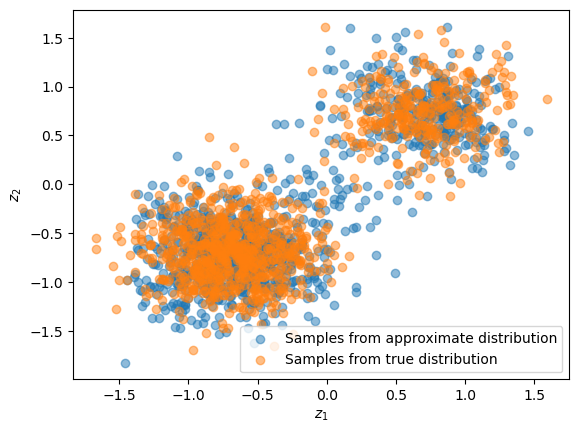

In [9]:
plt.scatter(z[:, 0], z[:, 1], alpha=.5, label='Samples from approximate distribution')
plt.scatter(generated_samples[:, 0], generated_samples[:, 1], alpha=0.5, label="Samples from true distribution")
plt.xlabel('$z_1$')
plt.ylabel('$z_2$')
plt.legend()
plt.show()